# Python calculation to be made for individual models

## 0. Packages and data

In [15]:
path='G:/Shared drives/BeStarsMiMeS/UpdatedFiles/' #Patrick's google file stream path

In [2]:
!git clone https://github.com/folsomcp/specpolFlow

Cloning into 'specpolFlow'...

Updating files:  95% (166/173)

Updating files:  96% (167/173)

Updating files:  97% (168/173)

Updating files:  98% (170/173)

Updating files:  99% (172/173)

Updating files: 100% (173/173)

Updating files: 100% (173/173), done.


## 2. Calculating model spectrum for each ModelCode - Federico


### Packages

In [4]:
import specpolFlow as pol
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
import os
import copy
import itertools

loading specpolFlow package


In [5]:
import pandas as pd
sheet_id = '1M6y1Wnsrc-w5FjUMfKaSFa_-foIDAaMe8W4lYNWnWyk'
sheet_name = 'Stars'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
StarData=pd.read_csv(url)

sheet_name = 'Observations'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
Observations=pd.read_csv(url)

### Calculations

In [6]:
#Star Data is the Stars worksheet

for i in StarData["ModelCode"]:
  model_code = i.upper()
  adopt_vsini = 50
  vmac = 2.0
  res = 65000

  file_mout = '{}00-InputMaterial/Synth-local-spectra/{}.mout'.format(path,model_code)
  file_int  = '{}ModelSpectrumvsini50/{}.dsk'.format(path,model_code)

  command = '/content/drive/Shareddrives/BeStarsMiMeS/Synth-codes/s3div.Linux {} {} {} {} 167000 {}'.format(file_mout, file_int, adopt_vsini, vmac, res)
  print(command)
  stream = os.popen(command)
  output = stream.readlines()
  
  print(output)

##~24min

/content/drive/Shareddrives/BeStarsMiMeS/Synth-codes/s3div.Linux /00-InputMaterial/Synth-local-spectra/T15000G40.mout /ModelSpectrumvsini50/T15000G40.dsk 50 2.0 167000 65000
[]
/content/drive/Shareddrives/BeStarsMiMeS/Synth-codes/s3div.Linux /00-InputMaterial/Synth-local-spectra/T15000G40.mout /ModelSpectrumvsini50/T15000G40.dsk 50 2.0 167000 65000
[]
/content/drive/Shareddrives/BeStarsMiMeS/Synth-codes/s3div.Linux /00-InputMaterial/Synth-local-spectra/T20000G35.mout /ModelSpectrumvsini50/T20000G35.dsk 50 2.0 167000 65000
[]
/content/drive/Shareddrives/BeStarsMiMeS/Synth-codes/s3div.Linux /00-InputMaterial/Synth-local-spectra/T25000G40.mout /ModelSpectrumvsini50/T25000G40.dsk 50 2.0 167000 65000
[]
/content/drive/Shareddrives/BeStarsMiMeS/Synth-codes/s3div.Linux /00-InputMaterial/Synth-local-spectra/T18000G40.mout /ModelSpectrumvsini50/T18000G40.dsk 50 2.0 167000 65000
[]
/content/drive/Shareddrives/BeStarsMiMeS/Synth-codes/s3div.Linux /00-InputMaterial/Synth-local-spectra/T21000G40.mo

## 3. How does the CII line that we used to check vsini depends on Teff and log(g)? - Federico

In [7]:
def read_disk(file):
  '''
  Read a synthetic spectrum from a s3div output

  :param file: The filename
  :rtype: wave, flux -- the wavelength in nm, and the normalized flux. 
  '''
  with open(file) as f:
    lines = f.readlines()
  # number of atomic lines in the header of the file
  natomic = int(lines[0].split(sep='-')[0])
  nwave=int(lines[natomic+1].split()[0])
  data = np.genfromtxt(lines[natomic+2:natomic+1+nwave])
  return(data[:,0]/10.0, data[:,1])


def split_order(data):
  '''
  Split an observation object into a list of observation objects with one order per item
  '''
  # one order is where the wavelength backtracks. 
  ind = np.where((data.wl[1:]-data.wl[0:-1]) < 0)[0]
  norder = ind.size+1
  ind = np.append(-1,ind)
  ind = np.append(ind,data.wl.size)
  print('{} orders'.format(norder))

  list_order=[]
  for i in range(0,norder):
    list_order.append(data[ind[i]+1:ind[i+1]])
 
  return(list_order)
  
def splice_order(list_order):
  '''
  Concatenate a list of observation objects (usually split into a list of orders by split_order function). Note: it does not merge the orders overlaps.
  '''
  wl = np.array([])
  specI = np.array([])
  specV = np.array([])
  specN1 = np.array([])
  specN2 = np.array([])
  specSig = np.array([])
  for item in list_order:
    wl=np.append(wl,item.wl)
    specI=np.append(specI,item.specI)
    specV=np.append(specV,item.specV)
    specN1=np.append(specN1,item.specN1)
    specN2=np.append(specN2,item.specN2)
    specSig=np.append(specSig, item.specSig)
  return(pol.iolsd.observation(wl, specI, specV, specN1, specN2, specSig, header=list_order[0].header))

def rshift(wave, radvel):
  '''
  Shift a spectrum in terms of radial velocity. The wavelength array and the velocity arrays must be defied as astropy units quantities.
  The new wavelength array is returned in the same units as the initial wavelength array. 
  '''
  return( (wave + wave*radvel/const.c).to(wave.unit).value )

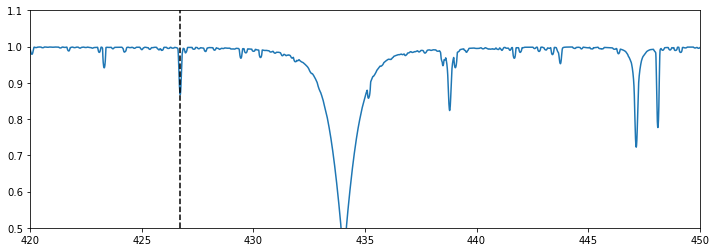

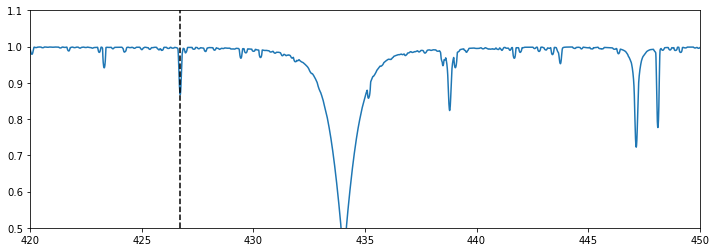

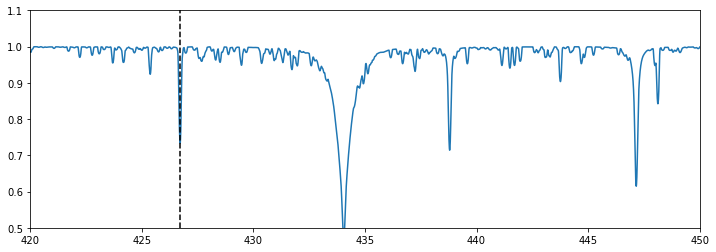

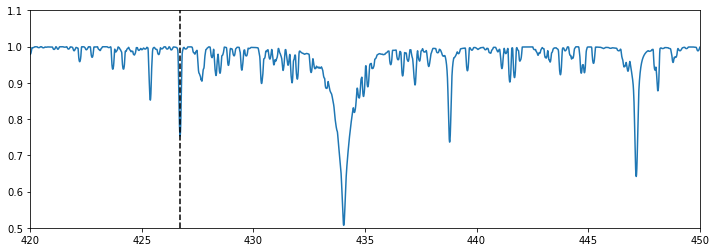

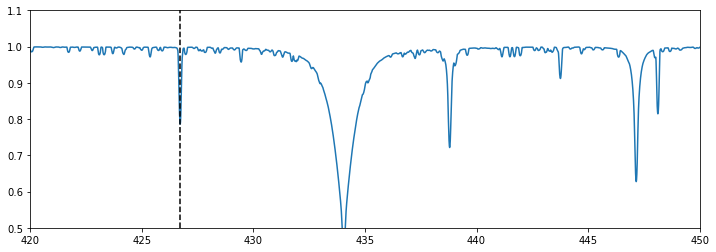

In [11]:
CII = 426.726 

c=0
import matplotlib.pyplot as plt

for i in StarData["ModelCode"]:
  if c > 4:
    break
  c = c+1
  modelcode = i.upper()  
  file_mod = '{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/ModelSpectrumvsini50/{}.dsk'.format(path,modelcode)
  mod_wave, mod_flux = read_disk(file_mod)

  fig, ax = plt.subplots(1,1, figsize=(12,4))
  ax.plot(mod_wave, mod_flux)
  ax.axvline(x=CII, c='k', ls='--')
  ax.set_xlim(420,450)
  ax.set_ylim(0.5,1.1)
  

In [12]:
CII = 426.726 

c=0

depth = []

T= []

Lg = []

for i in StarData["ModelCode"]:
  
  c = c+1
  modelcode = i.upper()  
  file_mod = '{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/ModelSpectrumvsini50/{}.dsk'.format(path,modelcode)
  mod_wave, mod_flux = read_disk(file_mod)


  apr_index = np.where(np.round(mod_wave - CII,2)==0)[0][0]
  


  wl = mod_wave[apr_index - 20:apr_index + 20]
  fl = mod_flux[apr_index - 20:apr_index + 20]

  index = np.argmin(fl)
  
  d = 1 - fl[index]

  depth.append(d)

  t=int(modelcode[1:6])
  T.append(t)

  g = int(modelcode[-2:])
  Lg.append(g)
  



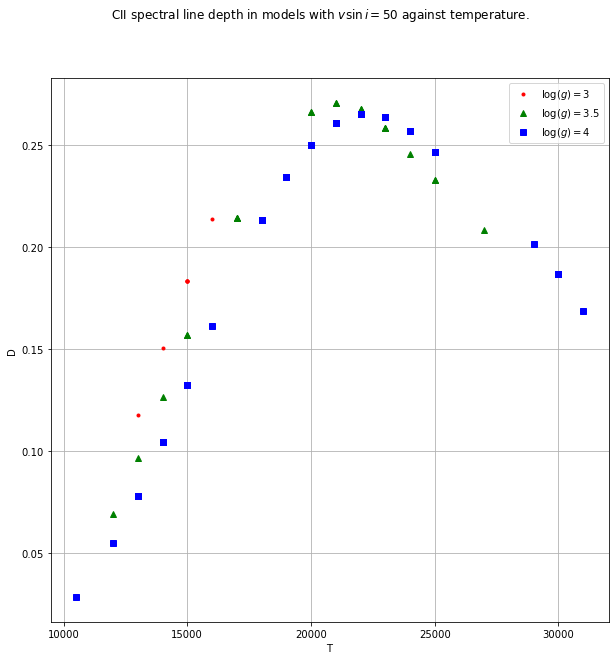

In [13]:
depth = np.array(depth)

T= np.array(T)

Lg = np.array(Lg)



r = np.where(Lg == 30)[0]
g = np.where(Lg == 35)[0]
b = np.where(Lg == 40)[0]


rT = []
rdepth = []

for i in r:
  rT.append(T[i])
  rdepth.append(depth[i])

gT = []
gdepth = []

for i in g:
  gT.append(T[i])
  gdepth.append(depth[i])

bT = []
bdepth = []

for i in b:
  bT.append(T[i])
  bdepth.append(depth[i])

from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('{}CII_linedepth_vs_Temp.pdf'.format(path)) as pdf:

  fig, ax = plt.subplots(1,1, figsize=(10,10))
  ax.plot(rT, rdepth,'.r',label=r'$\log(g)=3$')
  ax.plot(gT, gdepth,'^g',label=r'$\log(g)=3.5$')
  ax.plot(bT, bdepth,'sb',label=r'$\log(g)=4$')

  fig.suptitle('CII spectral line depth in models with '+ r'$v \sin{i}=50$' + ' against temperature.')
  ax.set_xlabel('T')
  ax.set_ylabel('D')
  ax.legend()
  ax.grid()

  #pdf.savefig(fig)


### Overplot synthetic spectra of lowest, peak and highest temperature.

These spectra correspond, in the same order, to the following codes:
T10500G40,T21000G35 ,T31000G40  


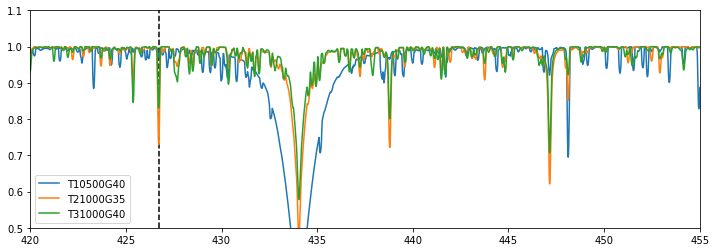

In [14]:
CII = 426.726 

c=0
import matplotlib.pyplot as plt

with PdfPages('{}CII_cases_overplot.pdf'.format(path)) as pdf:
  fig, ax = plt.subplots(1,1, figsize=(12,4))

  ax.axvline(x=CII, c='k', ls='--')
  ax.set_xlim(420,455)
  ax.set_ylim(0.5,1.1)

  for i in ['T10500G40','T21000G35','T31000G40']:
  
    c = c+1
    modelcode = i.upper()  
    file_mod = '{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/ModelSpectrumvsini50/{}.dsk'.format(path,modelcode)
    mod_wave, mod_flux = read_disk(file_mod)

    ax.plot(mod_wave, mod_flux,label='{}'.format(modelcode))
    
  ax.legend()
  pdf.savefig(fig)